In [1]:
%matplotlib inline

## Exemplo: Classificação de Imagens

Vamos aprender a implementar os seguintes passos:

1. Carregar e normalizar o conjunto de dados CIFAR10
2. Definir a estrutura de uma Rede Neural Convolucional
3. Definir um loop de treinamento
4. Treinar e testar a Rede Neural



In [16]:
## Carregar e normalizar o conjunto de dados CIFAR10

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Exibindo algumas imagens do conjunto de dados


       car      plane       ship       bird


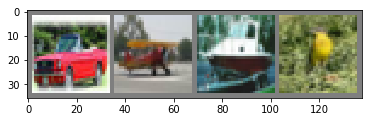

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

## Definindo a estrutura da Rede Neural


In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Função de perda e otimizador

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Loop de Treino


In [8]:
for epoch in range(2): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        #Forward
        inputs, labels = data
        outputs = net(inputs)
        
        #Backward
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Optimize
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.228
[1,  4000] loss: 1.880
[1,  6000] loss: 1.668
[1,  8000] loss: 1.573
[1, 10000] loss: 1.507
[1, 12000] loss: 1.462
[2,  2000] loss: 1.373
[2,  4000] loss: 1.367
[2,  6000] loss: 1.346
[2,  8000] loss: 1.327
[2, 10000] loss: 1.293
[2, 12000] loss: 1.283
Finished Training


## Testando o modelo

### Algumas imagens:


GroundTruth:    cat  ship  ship plane


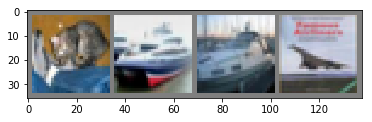

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
outputs = net(images)

In [11]:
#Obtem o vetor de predições
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship  ship


In [12]:
### Calculando acuracia

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 60 %
Accuracy of   car : 60 %
Accuracy of  bird : 49 %
Accuracy of   cat : 26 %
Accuracy of  deer : 41 %
Accuracy of   dog : 38 %
Accuracy of  frog : 57 %
Accuracy of horse : 65 %
Accuracy of  ship : 69 %
Accuracy of truck : 74 %


## Treinando na GPU


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


Enviando modelos para a GPU:

    inputs, labels = inputs.to(device), labels.to(device)
    net.to(device)

       
